In [14]:
import numpy as np
import tike
import xdesign as xd
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 8
BIGGER_SIZE = 8

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
NPIXEL = 64
PIXEL_SIZE = 1/NPIXEL
region = np.array([[-PIXEL_SIZE, PIXEL_SIZE], [-1, 1], [-1, 1]])/2

In [4]:
np.random.seed(0)
phantom = xd.DogaCircles(n_sizes=4, size_ratio=11/16, n_shuffles=64)
truth = xd.sidebyside(phantom, NPIXEL).T
# plt.show()

In [5]:
def circle_density(x, y, radius=PIXEL_SIZE/2):
    """Return True for (x,y) contained by the circle with given radius"""
    return x**2 + y**2 <= radius**2

def get_mask(A):
    """Return a boolean mask for dimensions 1 & 2 of A"""
    assert A.shape[0] == A.shape[1]
    radius = A.shape[0] / 2.0
    coords = np.arange(A.shape[0]) - A.shape[0] / 2.0 + 0.5,
    x, y = np.meshgrid(coords, coords)
    mask = circle_density(x, y, radius=radius)
    return mask

mask = get_mask(truth)
truth[~mask] = 0
# plt.imshow(truth)
# plt.show()
plt.close('all')

# Sampling diversity

Compare coverage maps for different distributions of angluar to transverse sampling for M allowed measurements. In other words, the total number of measurements, M, is divided into na, the number of unique angles, and nx, the number of unique transverse positions.

In [6]:
orders = 12
M = 2**orders
na = 2**np.arange(0,orders+1)
nx = 2**np.arange(orders,-1,-1)
ideal_mean = M / NPIXEL
num_repeats = 100
M, na, nx

(4096, array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
        2048, 4096]), array([4096, 2048, 1024,  512,  256,  128,   64,   32,   16,    8,    4,
           2,    1]))

In [7]:
xprobe = xd.Probe(size=PIXEL_SIZE)
gmin = region[1:, 0]
gsize = region[1:, 1] - gmin

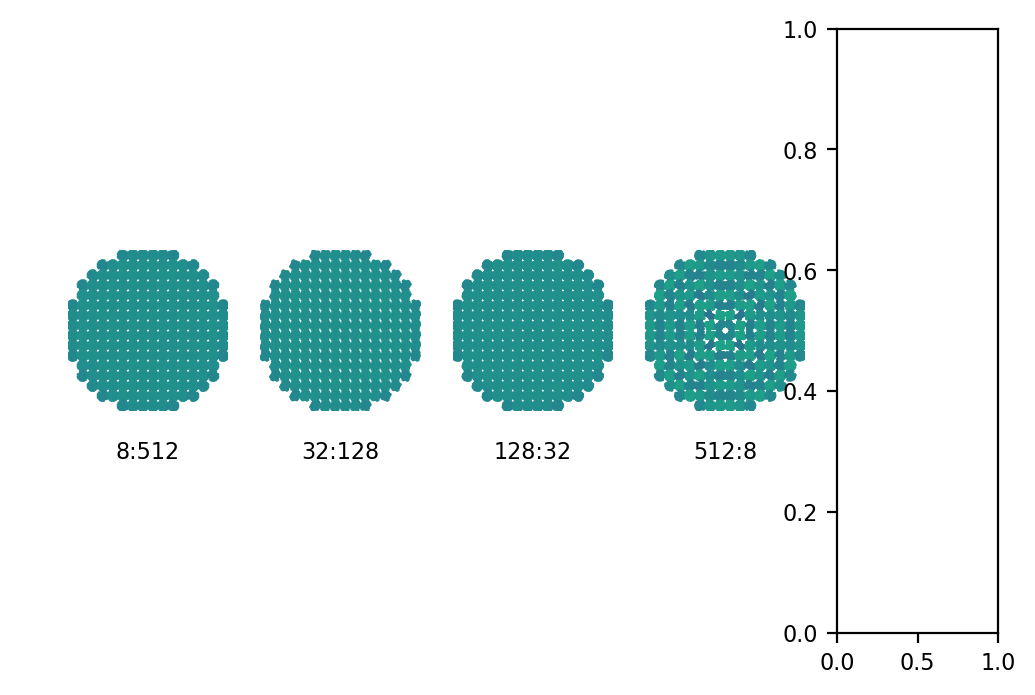

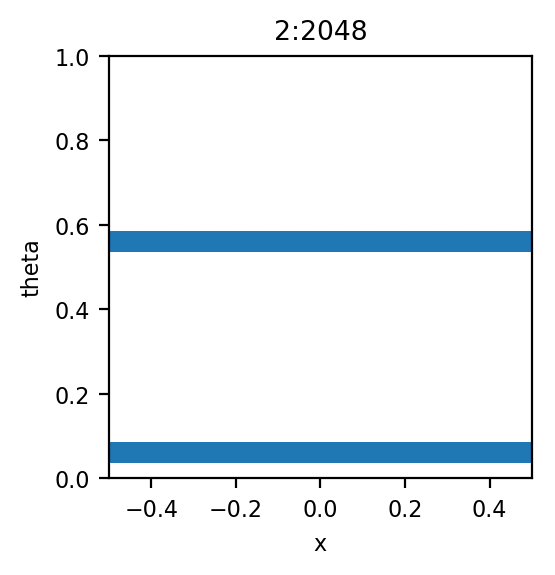

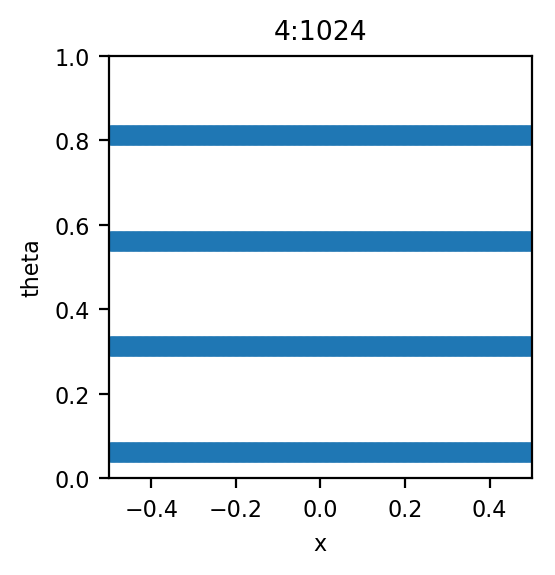

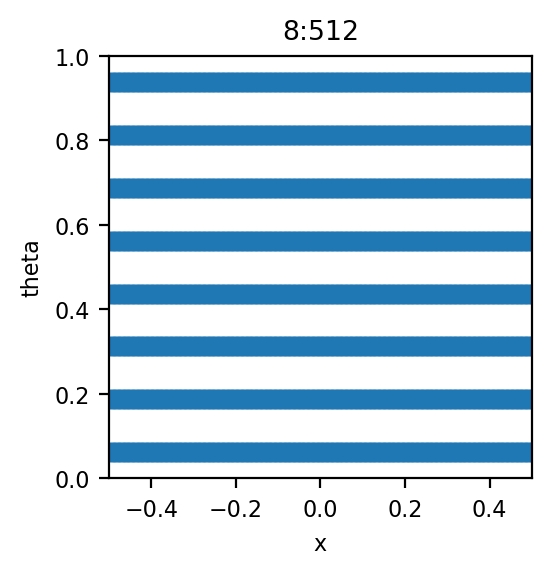

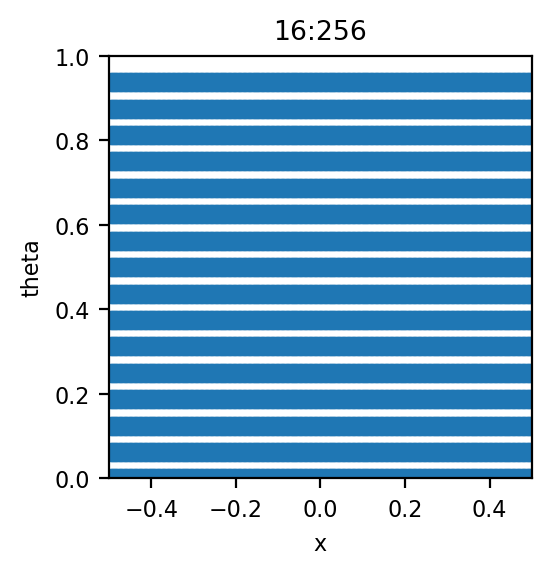

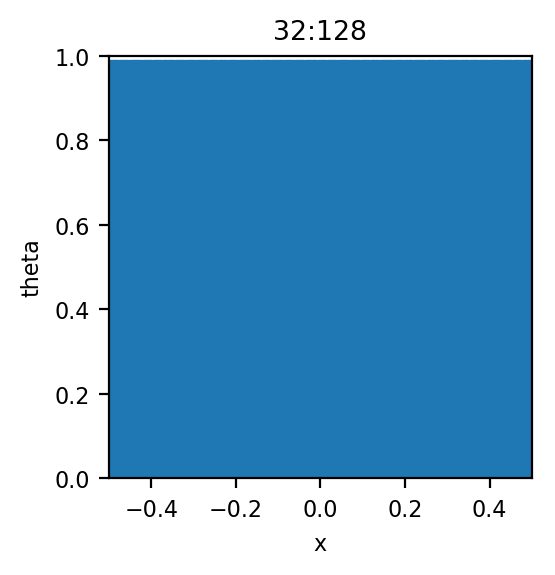

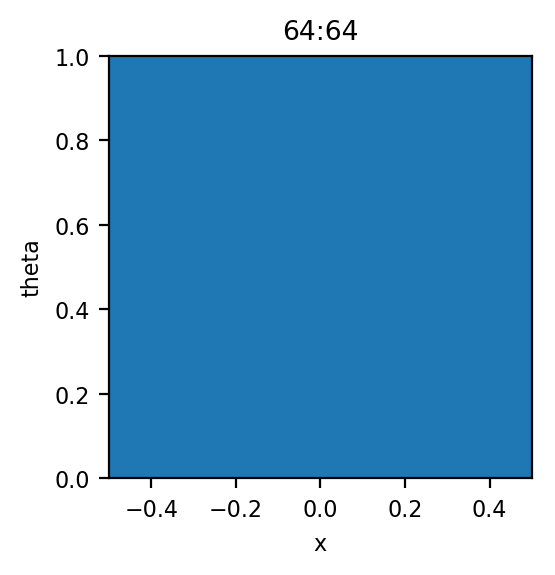

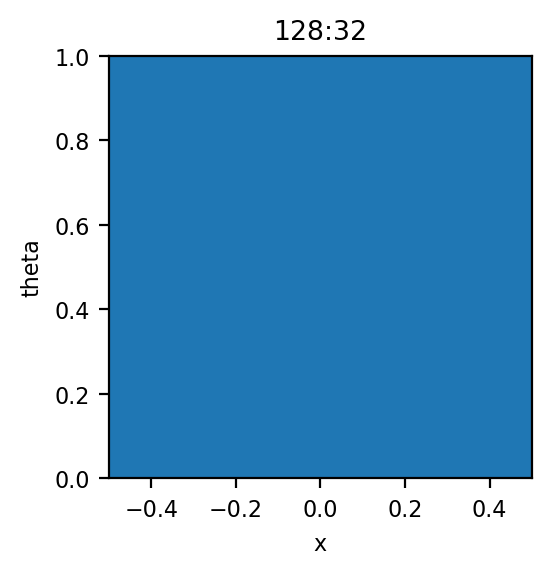

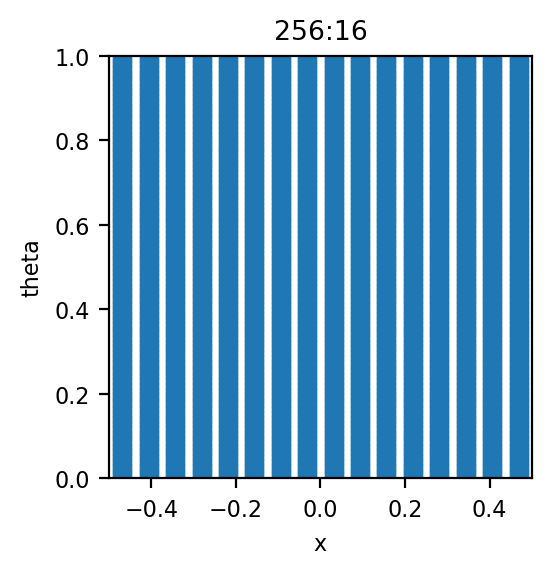

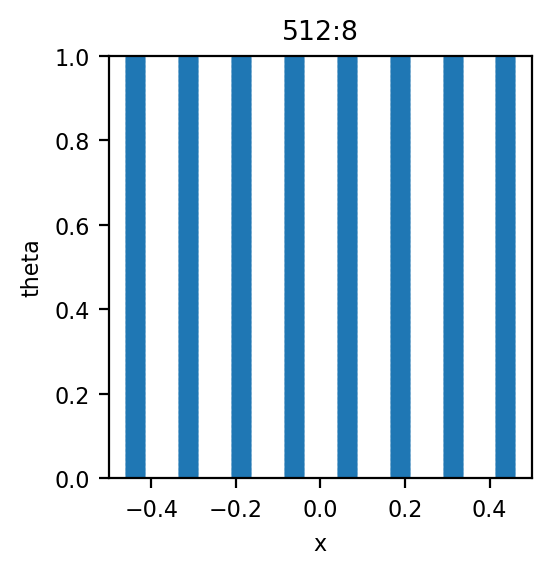

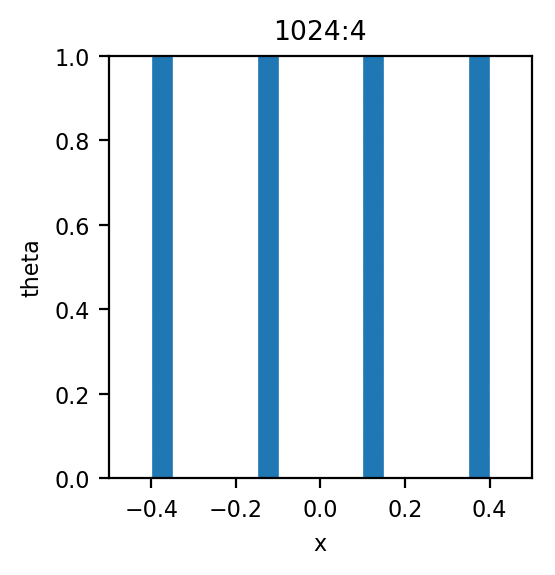

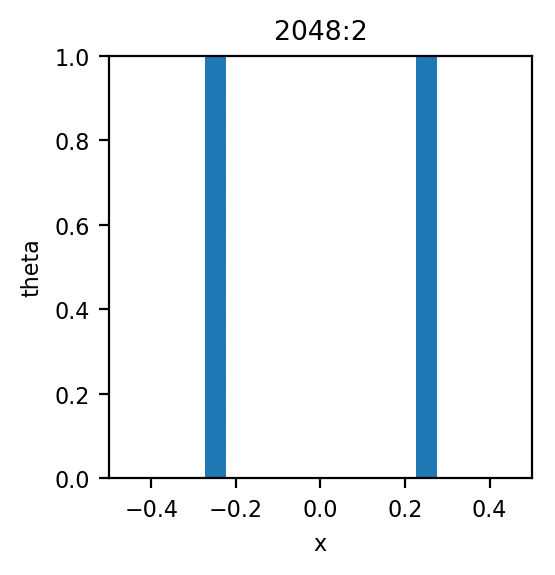

In [207]:
for NPIXEL in [16]: #, 32]: #64, 128, 256, 512]:
    PIXEL_SIZE = 1/NPIXEL

    for i in range(0, orders):
        theta, h = np.meshgrid(np.linspace(0, np.pi, na[i], endpoint=False),
                               np.linspace(0, 1, nx[i], endpoint=False) + 1/nx[i]/2)

    #     theta += np.atleast_2d(np.linspace(0, np.pi/na[i], nx[i])).T
    #     h += np.linspace(0, 1/nx[i], na[i])

        theta = (theta % np.pi + np.pi/16).flatten()
        h = (h % 1.0 - 0.5).flatten()

        plt.figure(dpi=200)
        ax1 = plt.subplot(1, 2, 1)
        ax1.scatter(h, theta % np.pi / np.pi)
        ax1.set_xlim([-0.5, 0.5])
        ax1.set_ylim([0, 1])
        ax1.set_aspect('equal')
        plt.xlabel('x')
        plt.ylabel('theta')
        plt.title('theta:x')

        cm = xd.coverage_approx(gmin, gsize, [NPIXEL, NPIXEL], PIXEL_SIZE, theta, h, h*0,
                                anisotropy=32, num_rays=16)
        np.save('./data/coverage/ratios/{}p_{}_{}.npy'.format(NPIXEL, na[i], nx[i]), cm)
#         ax2 = plt.subplot(1, 2, 2)
#         xd.plot_coverage_anisotropy(cm, trace_normal=(2*ideal_mean), color='anisotropy')
#         plt.axes().set_aspect('equal')
#         plt.colorbar()
        plt.title("{}:{}".format(na[i],nx[i]))
        plt.show()

    #     data = xprobe.measure(phantom, theta, h, h*0)

    #     np.save('./data/doga_grams/ratios/{}p_{}_{}.npy'.format(NPIXEL, na[i], nx[i]), [data, theta, h])

In [ ]:
# for i in range(2, orders-1):
#     m, theta, h = np.load('./data/doga_grams/ratios/{}p_{}_{}.npy'.format(NPIXEL, na[i], nx[i]))
#     v = h*0
#     for k in range(num_repeats):
#         m1 = m + m * 0.1 * np.random.normal(size=m.shape,scale=1)
#         init = np.zeros([NPIXEL, NPIXEL])
#         recons = xd.sirt(gmin, gsize, -np.log(m1), theta, h, v, init, niter=5*14, save_interval=5)
#         for j in range(len(recons)):
#             I = j*5
#             np.save('./data/doga_recons/ratios/{}p_{}_{}_I{:03d}_{:03d}.npy'.format(
#                 NPIXEL, na[i], nx[i], I, k), recons[j])

In [43]:
import pickle

In [ ]:


def get_quality_data(NPIXEL):
    
    truth = xd.sidebyside(phantom, NPIXEL).T
    mask = get_mask(truth)
    truth[~mask] = 0
    plt.close()
    
    w = [0.0448, 0.2858, 0.3001, 0.2363, 0.1333]
    nlevels = min(np.floor(np.log2(NPIXEL)-1).astype('int'), 5)
    quality_data = dict()
    for i in range(2, orders-1):
        I = 0
        iterations = list()
        quality = list()
        std = list()
        for I in range(0, 75, 5):
            repeats = list()
            for k in range(num_repeats):
                recons = np.load('./data/doga_recons/ratios/{}p_{}_{}_I{:03d}_{:03d}.npy'.format(
                    NPIXEL, na[i], nx[i], I, k))
                recons[~mask] = 0
                iq = xd.ImageQuality(truth, recons)
                iq.compute_quality(nlevels=nlevels)
                repeats.append(np.prod(iq.mets ** (w[0:nlevels] / np.sum(w[0:nlevels]))))
            iterations.append(I)
            quality.append(np.mean(repeats))
            std.append(np.std(repeats))
        quality_data[i] = [iterations, quality, std]
    return quality_data

qd_dictionary = dict()

sizes = [16, 32, 64, 128, 256, 512, 1024]

for size in sizes:
    qd_dictionary[size] = get_quality_data(size)

with open( "./data/fixed_quality.p", "wb" ) as file:
    pickle.dump(qd_dictionary, file)

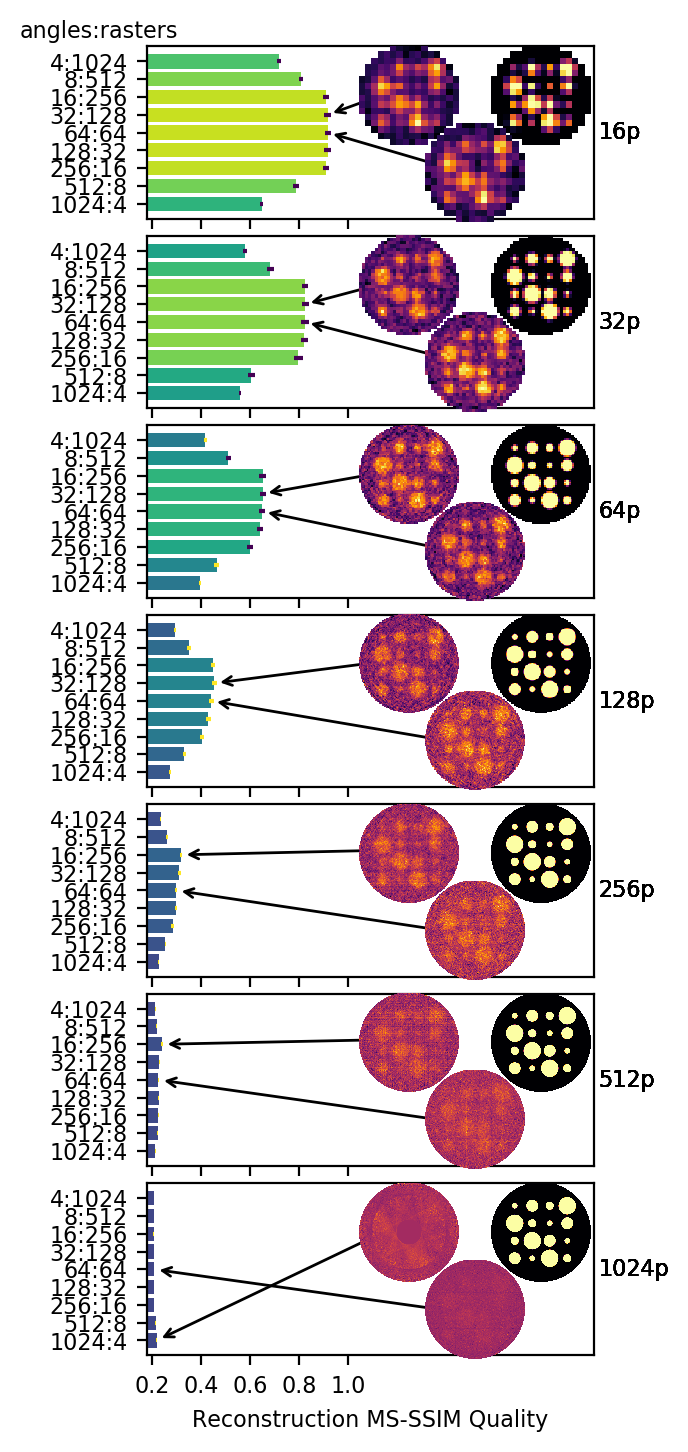

In [228]:
with open( "./data/fixed_quality.p", "rb" ) as file:
    qd_dictionary = pickle.load(file)

import matplotlib
matplotlib.rcParams.update({'font.size': 8})
import mpl_toolkits.axes_grid1.inset_locator as mil

sizes = [16, 32, 64, 128, 256, 512, 1024]
best =  [ 5,  5,  5,   5,   4,   4,   10]

F1 = plt.figure(figsize=(8.4/2.54, 1.1*len(sizes)), dpi=200, frameon=False)
A = plt.subplot(len(sizes), 1, 1)

labels = ["{:d}:{:d}".format(na[i],nx[i]) for i in range(2, orders-1)]

for j, size in enumerate(sizes):
    
    quality_data = qd_dictionary[size]

    plt.figure(F1.number)

    B = plt.subplot(len(sizes), 1, j+1, sharex=A, sharey=A)
    
    if j == 0:
        plt.annotate("angles:rasters", (0.07, 1.05), xycoords='axes fraction', ha='right')

    for i in range(2, orders-1):        
        iterations, quality, std = quality_data[i]
        quality[0] = 0
        k = np.argmax(quality)
        max_qual = quality[k]
        std_qual = std[k]
        _ecolor = 1.0 if max_qual < 0.5 else 0.0
        B.barh(i, max_qual, xerr=std_qual,
               color=plt.cm.viridis(max_qual),
               ecolor=plt.cm.viridis(_ecolor))
        plt.annotate("{}p".format(size), (1.01, 0.5),
            xycoords='axes fraction', va='center', ha='left')
#         plt.annotate("{}:{}".format(na[i],nx[i]), (1.01, 0.5),
#                  xycoords='axes fraction', va='center', ha='left')
        if i == best[j]:
            plt.annotate(s='bla', xy=(max_qual,i), xytext=(1.1,4.1), arrowprops=dict(arrowstyle='->'))
        if i == 6:
            plt.annotate(s='bla', xy=(max_qual,i), xytext=(1.5,9), arrowprops=dict(arrowstyle='->'))
    if j < len(sizes) -1:
        plt.setp(B.get_xticklabels(), visible=False)
    else:
        plt.xlabel('Reconstruction MS-SSIM Quality')
    B.set_yticks(range(2, orders-1))
    B.set_yticklabels(labels)
    B.set_ylim(B.get_ylim()[::-1])
    plt.xlim([0.18, 2])
    B.set_xticks([.2, .4, .6, .8, 1.])


    plt.subplots_adjust(hspace=0.1, top=0.95, bottom=0.1, left=0.2, right=0.875)

# for j, size in enumerate(sizes):
    
#     B = plt.subplot(len(sizes), 1, j+1, sharex=A, sharey=A)
    Bcorner = B.get_position().bounds
    
    NPIXEL = sizes[j]
    truth = xd.sidebyside(phantom, NPIXEL).T
    mask = get_mask(truth)
    truth[~mask] = np.nan
    plt.close()
    
    inset_size = 0.15
    
#     print(Bcorner[1], Bcorner[3])
    B1 = F1.add_axes([Bcorner[0] + 0.52, Bcorner[1]+0.005, inset_size, inset_size])
    plt.imshow(truth, origin='lower', cmap=plt.cm.inferno)
    plt.axis('off')
    
#     B2 = mil.inset_axes(B, inset_size, inset_size, loc='lower center')
    B2 = F1.add_axes([Bcorner[0] + 0.32, Bcorner[1]+0.005, inset_size, inset_size])
    i = best[j]
    recons = np.load('./data/doga_recons/ratios/{}p_{}_{}_I{:03d}_000.npy'.format(NPIXEL, na[i], nx[i], I))
    recons[~mask] = np.nan
    plt.imshow(recons, origin='lower', cmap=plt.cm.inferno)
#     plt.setp(B2.get_yticklabels(), visible=False)
#     plt.setp(B2.get_xticklabels(), visible=False)
    # plt.annotate('(b)', (0,0), color='white', va='bottom')
    plt.axis('off')
    
#     B3 = mil.inset_axes(B, inset_size, inset_size, loc='center left')
    B3 = F1.add_axes([Bcorner[0] + 0.42, Bcorner[1]-0.045, inset_size, inset_size])
    i = 6
    recons = np.load('./data/doga_recons/ratios/{}p_{}_{}_I{:03d}_000.npy'.format(NPIXEL, na[i], nx[i], I))
    recons[~mask] = np.nan
    plt.imshow(recons, origin='lower', cmap=plt.cm.inferno)
#     plt.setp(B3.get_yticklabels(), visible=False)
#     plt.setp(B3.get_xticklabels(), visible=False)
    # plt.annotate('(b)', (0,0), color='white', va='bottom')
    plt.axis('off')
    plt.draw()
    
# plt.annotate("SIRT iterations", (0.05, 0.5), rotation=90, ha='center', va='center', xycoords='figure fraction')

plt.savefig('./figures/fixed_quality.pdf', dpi=600, pad_inches=0)
plt.savefig('./figures/fixed_quality.png', dpi=600, pad_inches=0)
plt.show()

In [118]:
B1.get_position().bounds

(0.20000000000000001,
 0.14285714285714285,
 0.14999999999999997,
 0.064285714285714252)

In [144]:
Bcorner[3]/4

0.027960526315789463

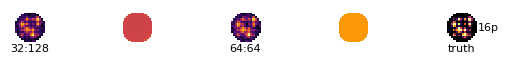

In [26]:
I = 25
plt.figure(figsize=(3.3, 10), dpi=200)

csize = 16
truth = xd.sidebyside(phantom, csize).T
cmask = get_mask(truth)

sizes = [16, 32, 64, 128, 256, 512, 1024]
best =  [5, 5, 5, 5, 4, 4, 10]

for j in range(0, 1 ): # 7):

    NPIXEL = sizes[j]
    truth = xd.sidebyside(phantom, NPIXEL).T
    mask = get_mask(truth)
    truth[~mask] = 0
    plt.close()
    
    i = best[j]
    B = plt.subplot(7, 5, 5*j+1)
    recons = np.load('./data/doga_recons/ratios/{}p_{}_{}_I{:03d}_000.npy'.format(NPIXEL, na[i], nx[i], I))
    recons[~mask] = np.nan
    plt.imshow(recons, origin='lower', cmap=plt.cm.inferno)
    plt.setp(B.get_yticklabels(), visible=False)
    plt.setp(B.get_xticklabels(), visible=False)
    # plt.annotate('(b)', (0,0), color='white', va='bottom')
    plt.axis('off')
    plt.annotate("{}:{}".format(na[i],nx[i]), (0.5, -0.3), xycoords='axes fraction', ha='center', fontsize=8)
    

    cm = np.load('./data/coverage/ratios/{}p_{}_{}.npy'.format(csize, na[i], nx[i]))
    B1 = plt.subplot(7, 5, 5*j+2)
    cm[~cmask, :] = np.nan
    xd.plot_coverage_anisotropy(cm, trace_normal=10, color='standard deviation')
    plt.axis('off')

    i = 6
    C = plt.subplot(7, 5, 5*j+3)
    recons = np.load('./data/doga_recons/ratios/{}p_{}_{}_I{:03d}_000.npy'.format(NPIXEL, na[i], nx[i], I))
    recons[~mask] = np.nan
    plt.imshow(recons, origin='lower', cmap=plt.cm.inferno)
    plt.setp(B.get_yticklabels(), visible=False)
    plt.setp(B.get_xticklabels(), visible=False)
    # plt.annotate('(b)', (0,0), color='white', va='bottom')
    plt.axis('off')
    plt.annotate("{}:{}".format(na[i],nx[i]), (0.5, -0.3), xycoords='axes fraction', ha='center', fontsize=8)

    
    cm = np.load('./data/coverage/ratios/{}p_{}_{}.npy'.format(csize, na[i], nx[i]))
    B1 = plt.subplot(7, 5, 5*j+4)
    cm[~cmask, :] = np.nan
    xd.plot_coverage_anisotropy(cm, trace_normal=10, color='standard deviation')
    plt.axis('off')

    # TRUTH
    plt.subplot(7, 5, 5*j+5)
    mtruth = truth.copy()
    mtruth[~mask] = np.nan
    plt.imshow(mtruth, origin='lower', cmap=plt.cm.inferno)
    plt.setp(B.get_yticklabels(), visible=False)
    plt.setp(B.get_xticklabels(), visible=False)
    plt.axis('off')
    plt.annotate("truth", (0.5, -0.3), xycoords='axes fraction', ha='center', fontsize=8)
    plt.annotate("{}p".format(NPIXEL), (1.05, 0.5),
                 xycoords='axes fraction', va='center', ha='left')

plt.subplots_adjust(wspace=0.0, top=0.99, bottom=0.01, left=0.0, right=0.9, hspace=0.5)
# plt.savefig('./figures/fixed_recon_compare.pdf'.format(NPIXEL), dpi=600, pad_inches=0)
# plt.savefig('./figures/fixed_recon_compare.png'.format(NPIXEL), dpi=600, pad_inches=0)
plt.show()

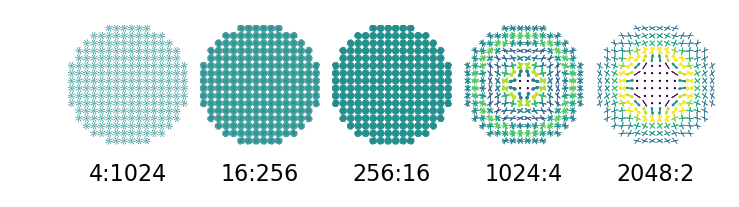

In [227]:
csize = 16
truth = xd.sidebyside(phantom, csize).T
cmask = get_mask(truth)
ideal_mean = M / csize
plt.close('all')

plt.figure(figsize=(8.4/2.54, 0.9), dpi=200)
j = 0
for i in [2, 4, 8, 10, 11]: #range(2, orders-1):
    j += 1
    plt.subplot(1, 5, j)
    cm = np.load('./data/coverage/ratios/{}p_{}_{}.npy'.format(csize, na[i], nx[i]))
    cm[~cmask, :] = np.nan
    xd.plot_coverage_anisotropy(cm, trace_normal=(2*ideal_mean), color='coverage', linewidth=0.1)
    plt.axis('off')
    plt.annotate("{}:{}".format(na[i],nx[i]), (0.5, -0.3), xycoords='axes fraction', ha='center', fontsize=8)

plt.subplots_adjust(wspace=0.1, top=1.0, bottom=0.1, left=0.01, right=0.99, hspace=0.0)
plt.savefig('./figures/fixed_coverage_compare.pdf'.format(NPIXEL), dpi=600, pad_inches=0)
plt.savefig('./figures/fixed_coverage_compare.png'.format(NPIXEL), dpi=600, pad_inches=0)
plt.show()

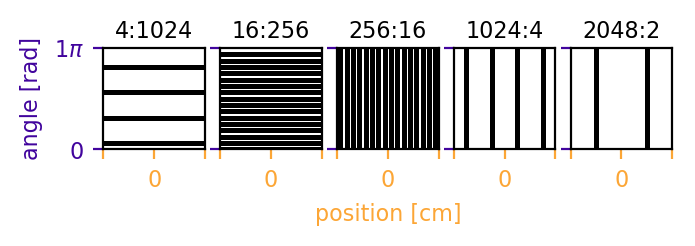

In [55]:
blue = plt.cm.plasma(0.1)
red = plt.cm.plasma(0.8)
csize = 16
truth = xd.sidebyside(phantom, csize).T
cmask = get_mask(truth)
ideal_mean = M / csize
plt.close('all')

plt.figure(figsize=(8.4/2.54, 1.1), dpi=200)
j = 0
for i in [2, 4, 8, 10, 11]: #range(2, orders-1):
    j += 1
    ax1 = plt.subplot(1, 5, j)
    theta, h = np.meshgrid(np.linspace(0, np.pi, na[i], endpoint=False),
                           np.linspace(0, 1, nx[i], endpoint=False) + 1/nx[i]/2)


    theta = (theta % np.pi + np.pi/16).flatten()
    h = (h % 1.0 - 0.5).flatten()

    ax1.scatter(h, theta % np.pi / np.pi, s=0.5, color='black')
    ax1.set_xlim([-0.5, 0.5])
    ax1.set_ylim([0, 1])
    ax1.set_aspect('equal')
    plt.xticks([-.5, 0, 0.5], ['', 0, ''], color=red)
    if i == 2:
        plt.ylabel('angle [rad]', color=blue, fontsize=8)
        plt.yticks([0, 1], [0, '$1\pi$'], color=blue)
    else:
        plt.yticks([0, 1], ['', ''], color=blue)
    if i == 8:
        ax1.set_xlabel('position [cm]', color=red, fontsize=8)
    ax1.tick_params('y', colors=blue)
    ax1.tick_params('x', colors=red)
#     plt.xlabel('x')
#     plt.ylabel('theta')
#     plt.title('theta:x')
    
    
    plt.annotate("{}:{}".format(na[i],nx[i]), (0.5, 1.1), xycoords='axes fraction', ha='center', fontsize=8)

plt.subplots_adjust(wspace=0.15, top=0.99, bottom=0.15, left=0.13, right=0.99, hspace=0.0)
plt.savefig('./figures/fixed_trajectory_compare.pdf'.format(NPIXEL), dpi=600, pad_inches=0)
plt.savefig('./figures/fixed_trajectory_compare.png'.format(NPIXEL), dpi=600, pad_inches=0)
plt.show()
plt.close('all')

In [217]:
orders

12